In [1]:
!nvidia-smi

Thu Apr 11 05:37:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
def load_current_env():
    '''獲取當前目標的絕對路徑，且添加 Python 環境'''

    import os
    # 獲取根目錄
    try:  # colab 目錄
        from google.colab import drive
        root = '/content/drive'  # colab 訓練
        drive.mount(root)  # 掛載雲端硬碟
        root = f'{root}/MyDrive'
    except:
        root = '.'  # 本地目錄
    # 添加當前路徑為 Python 包所在環境
    # 保證 colab 可以獲取自訂義的 .py 文件
    os.chdir(root)

load_current_env()

Mounted at /content/drive


Found 6411 images belonging to 2 classes.
Found 640 images belonging to 2 classes.
Found 640 images belonging to 2 classes.
Epoch 1/2
201/201 [==============================] - 955s 5s/step - loss: 0.1203 - accuracy: 0.9635 - val_loss: 0.0300 - val_accuracy: 0.9906
Epoch 2/2
201/201 [==============================] - 119s 590ms/step - loss: 0.0760 - accuracy: 0.9786 - val_loss: 0.0051 - val_accuracy: 1.0000


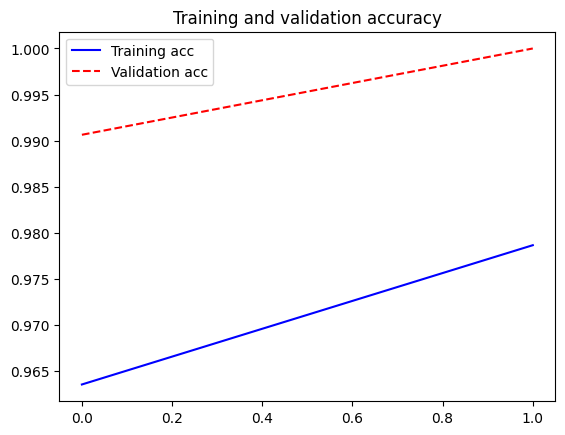

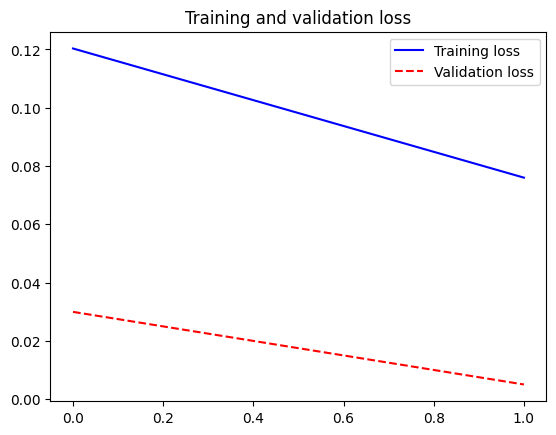

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 160s 8s/step - loss: 0.0157 - accuracy: 0.9953


In [7]:
import numpy as np
import os
from pathlib import Path
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet152

def mkdir(out_dir):
    out_dir = Path(out_dir)
    if not out_dir.exists():
        out_dir.mkdir(parents=True, exist_ok=True)

def load_current_env():
    try:
        from google.colab import drive
        root = '/content/drive'
        drive.mount(root)
        root = f'{root}/MyDrive'
    except:
        root = '.'
    os.chdir(root)

def load_data(train_data_dir,
              validation_data_dir,
              test_data_dir,
              batch_size,
              target_size=(224, 224),
              class_mode='binary'):

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    validation_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input)

    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode=class_mode)

    validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                                  shuffle=False,
                                                                  target_size=target_size,
                                                                  batch_size=batch_size,
                                                                  class_mode=class_mode)

    test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                      target_size=target_size,
                                                      batch_size=batch_size,
                                                      interpolation='bicubic',
                                                      class_mode=class_mode,
                                                      shuffle=False)
    return train_generator, validation_generator, test_generator

def create_model(base_model):
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    base_model.trainable = False
    return model

def create_history(model, epochs, batch_size, train_generator, validation_generator, checkpoint_filepath='../checkpoint'):
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='auto', save_freq='epoch',
        save_best_only=True)

    history = model.fit(x=train_generator,
                        batch_size=train_generator.n // batch_size,
                        epochs=epochs,
                        validation_data=validation_generator,
                        validation_steps=validation_generator.n // batch_size,
                        callbacks=[model_checkpoint_callback])
    return history

def write_csv_result(save_dir, model_name, accs, val_accs, losses, val_losses):
    with open(f"{save_dir}/{model_name}_train_acc.csv", "w") as f:
        [f.write(str(acc)+'\n') for acc in accs]
    with open(f"{save_dir}/{model_name}_train_loss.csv", "w") as f:
        [f.write(str(loss)+'\n') for loss in losses]
    with open(f"{save_dir}/{model_name}_val_acc.csv", "w") as f:
        [f.write(str(acc)+'\n') for acc in val_accs]
    with open(f"{save_dir}/{model_name}_val_loss.csv", "w") as f:
        [f.write(str(loss)+'\n') for loss in val_losses]

def plot_history(history, save_dir, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    write_csv_result(save_dir, model_name, acc, val_acc, loss, val_loss)
    plt.plot(acc, 'b', label='Training acc')
    plt.plot(val_acc, 'r--', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig(
        f'{save_dir}/{model_name}_training_validation_accuracy.png')
    plt.figure()

    plt.plot(loss, 'b', label='Training loss')
    plt.plot(val_loss, 'r--', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig(
        f'{save_dir}/{model_name}_training_validation_loss.png')
    plt.show()

root = '/content/drive/My Drive/'
train_data_dir = f'{root}/myData3200/train'
val_data_dir = f'{root}/myData3200/validation'
test_data_dir = f'{root}/myData3200/test'

target_size = 224, 224
batch_size = 32
class_mode = 'binary'

train_gen, val_gen, test_gen = load_data(train_data_dir,
                                        val_data_dir,
                                        test_data_dir,
                                        batch_size,
                                        target_size,
                                        class_mode)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

resnet152_model = create_model(ResNet152(weights='imagenet', include_top=False))
resnet152_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

epochs = 2

model_save_dir = '/content/drive/My Drive/resnet152_Adam_DefaultValue'
mkdir(model_save_dir)

save_dir = '/content/drive/My Drive/resnet152_Adam_DefaultValue'
mkdir(save_dir)

model_name = 'resnet152'

checkpoint_filepath = f'{save_dir}/{model_name}/'+ 'weights.{epoch:03d}-{val_loss:.7f}.h5'

resnet152_history = create_history(
    resnet152_model, epochs, batch_size,
    train_gen, val_gen,
    checkpoint_filepath)

plot_history(resnet152_history, save_dir, model_name)
resnet152_model.save(f'{model_save_dir}/{model_name}.h5')

def test_result(model, test_generator, batch_size):
    results = model.evaluate(x=test_generator,
                                         batch_size=batch_size,
                                        return_dict=True)
    return results

resnet152_results = test_result(resnet152_model, test_gen, batch_size)
